In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

48

In [2]:
#%run ../../core/prepare_histograms.py
#%run ../../core/event_numbers.py

# Imports

In [3]:
import pickle
import numpy as np
import astropy.units as u

import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from tools import *
from settings import *
import matplotlib.pyplot as plt
import seaborn as sns

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# load 4FGL-DR3 catalog by Fermi

In [4]:
from astropy.io import fits

In [164]:
# 4FGL - DR4 catalog
with fits.open(LOCALPATH+"/gll_psc_v35.fit") as fgl4:
    #print(fgl4.info())
    #print(fgl4[1])
    #print(fgl4[1].data)
    #print(fgl4[1].columns)
    data_4FGL = fgl4[1].data
    print(fgl4[1].data['Source_Name'])
    print(fgl4[1].data['RAJ2000'])
    print(fgl4[1].data['DEJ2000'])


['4FGL J0000.3-7355' '4FGL J0000.5+0743' '4FGL J0000.7+2530' ...
 '4FGL J2359.7-5041' '4FGL J2359.9-3736' '4FGL J2359.9+3145']
[9.830000e-02 1.375000e-01 1.878000e-01 ... 3.599365e+02 3.599816e+02
 3.599908e+02]
[-73.922    7.7273  25.5153 ... -50.6853 -37.616   31.7601]


In [6]:
data_4FGL['Source_Name'],data_4FGL['RAJ2000'],data_4FGL['DEJ2000']

(chararray(['4FGL J0000.3-7355', '4FGL J0000.5+0743', '4FGL J0000.7+2530',
            ..., '4FGL J2359.7-5041', '4FGL J2359.9-3736',
            '4FGL J2359.9+3145'], dtype='<U18'),
 array([9.830000e-02, 1.375000e-01, 1.878000e-01, ..., 3.599365e+02,
        3.599816e+02, 3.599908e+02], dtype='>f4'),
 array([-73.922 ,   7.7273,  25.5153, ..., -50.6853, -37.616 ,  31.7601],
       dtype='>f4'))

In [7]:
txs_mask = data_4FGL['Source_Name'] == "4FGL J0509.4+0542"

In [8]:
skycoords_4FGL = SkyCoord(ra=data_4FGL['RAJ2000'], dec=data_4FGL['DEJ2000'], unit="deg", frame="fk5", obstime="J2000")


In [143]:
skycoords_4FGL[txs_mask]

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(77.3593, 5.7014)]>

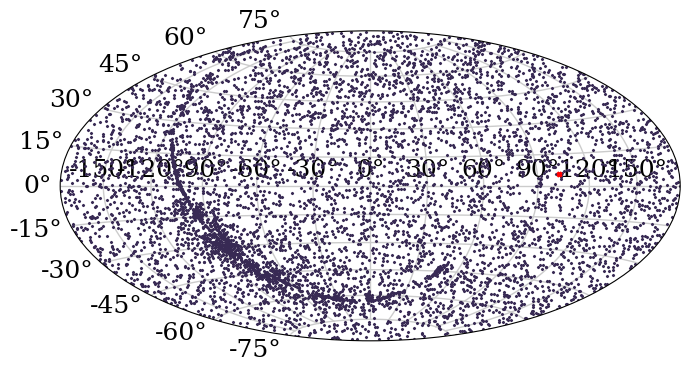

In [10]:
f = plt.figure()
ax = f.add_subplot(111, projection="hammer", rasterized=True)
ax.scatter(np.pi - skycoords_4FGL.ra.rad, skycoords_4FGL.dec.rad, marker="x", s=1)
ax.scatter(np.pi - skycoords_4FGL[txs_mask].ra.rad, skycoords_4FGL[txs_mask].dec.rad, marker="x", s=10, color="red")

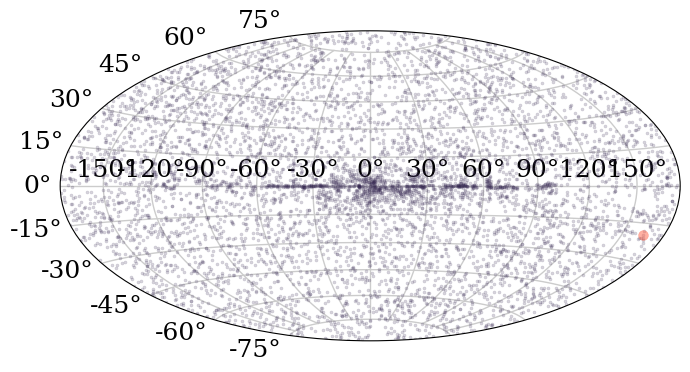

In [11]:
f = plt.figure()
ax = f.add_subplot(111, projection="hammer", rasterized=True)
ax.scatter(np.pi - (skycoords_4FGL.galactic.l.rad + np.pi) % (2*np.pi), skycoords_4FGL.galactic.b.rad, marker="o", s=5, alpha=0.2)
ax.scatter(np.pi - (skycoords_4FGL[txs_mask].galactic.l.rad + np.pi) % (2*np.pi), skycoords_4FGL[txs_mask].galactic.b.rad, marker="o", s=50, color="tomato", alpha=0.5)

# Baseline plot 

In [12]:
from tools import add_plane

In [13]:
plenum_detectors = ["IceCube", "P-ONE", "KM3NeT", "Baikal-GVD"]
clon = poles["P-ONE"]["lon"].value #0


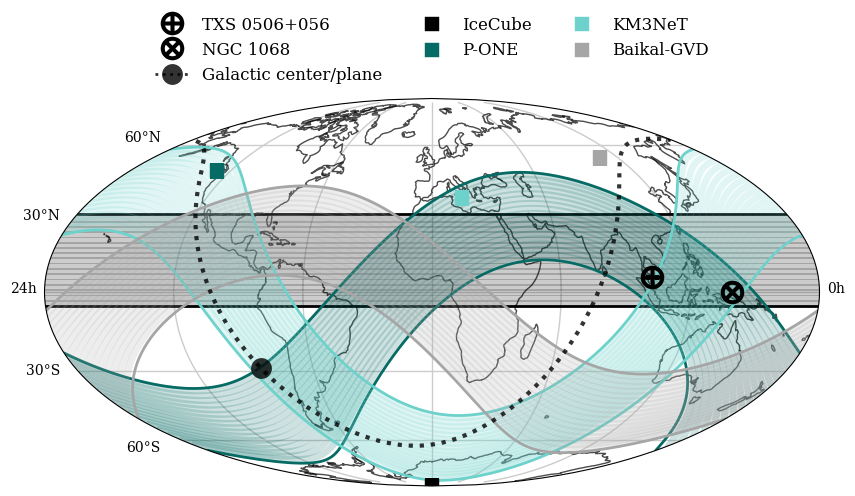

In [14]:
for ii, clon in enumerate([0]): #, poles["P-ONE"]["lon"].value
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=clon))
    ax.set_global()
    ax.coastlines(color="k", alpha=0.7, lw=1)
    ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, zorder=0)
    ax.text(-0.01, 0.5, "24h", transform=ax.transAxes, ha="right")
    ax.text(1.01, 0.5, "0h", transform=ax.transAxes, ha="left")
    ax.text(0.15, 0.9, "60°N", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.02, 0.7, "30°N", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.02, 0.3, "30°S", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.15, 0.1, "60°S", transform=ax.transAxes, ha="right", va="center")

    if True:
        add_obj(
            ax,
            "txs",
            marker=r"$\bigoplus$",
            c="k",
            transform=ccrs.PlateCarree(central_longitude=clon),
            markeredgewidth=2,
            zorder=10,
        )
        add_obj(
            ax,
            "ngc",
            marker=r"$\bigotimes$",
            c="k",
            transform=ccrs.PlateCarree(central_longitude=clon),
            markeredgewidth=2,
            zorder=10,
        )
        add_plane(
            ax, color="black", transform=ccrs.PlateCarree(central_longitude=clon), zorder=10
        )

    zen_min = -30
    zen_max = 5
    azi = np.linspace(0, 360, num=200)
    zen1 = np.full_like(azi, zen_min)
    zen2 = np.full_like(azi, zen_max)
    for k in plenum_detectors:
        ax.scatter(
            poles[k]["lon"].value,
            poles[k]["lat"].value,
            color=poles[k]["color"],
            marker="s",
            s=100,
            transform=ccrs.PlateCarree(),
            label=k,
            zorder=10,
        )
        rotated_crs = ccrs.RotatedPole(
            pole_longitude=poles[k]["lon"].value,
            pole_latitude=poles[k]["lat"].value,
        )
        ax.plot(
            azi, zen1, transform=rotated_crs, color=poles[k]["color"], lw=2, alpha=1
        )
        ax.plot(
            azi, zen2, transform=rotated_crs, color=poles[k]["color"], lw=2, alpha=1
        )

        for i in range(zen_min+2, zen_max, 2):
            zen = np.full_like(azi, i)
            ax.plot(
                azi,
                zen,
                transform=rotated_crs,
                color=poles[k]["color"],
                lw=5,
                alpha=0.2,
            )
    plt.subplots_adjust(top=0.8)
    ax.legend(
        fontsize="large",
        loc="lower center",
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, 1.0),
    )
    # fig.tight_layout()
    base_file = join(BASEPATH, f"plots/maps/best_field_of_view_map_{ii}") #_with_TRIDENT")
    fig.savefig(base_file + ".pdf", bbox_inches="tight")
    fig.savefig(base_file + ".png", bbox_inches="tight")


# galactic coordinates

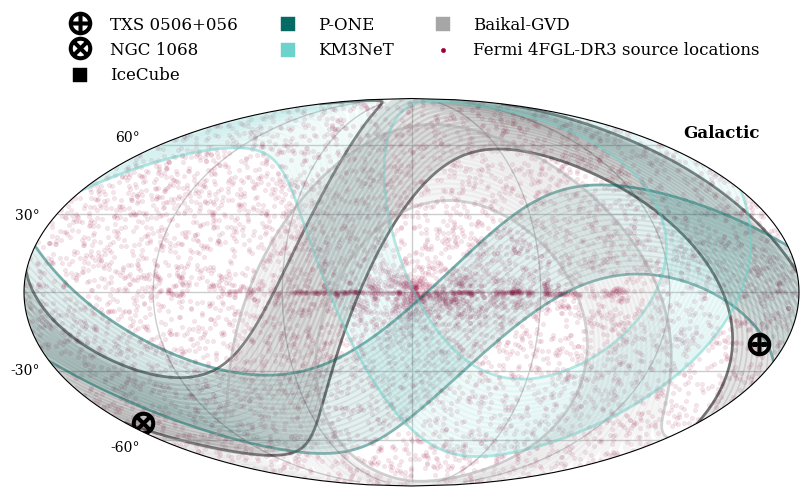

In [15]:
ii = 0
clon = 0
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=clon))
ax.set_global()
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, zorder=0)

ax.text(0.15, 0.9, "60°", transform=ax.transAxes, ha="right", va="center")
ax.text(0.02, 0.7, "30°", transform=ax.transAxes, ha="right", va="center")
ax.text(0.02, 0.3, "-30°", transform=ax.transAxes, ha="right", va="center")
ax.text(0.15, 0.1, "-60°", transform=ax.transAxes, ha="right", va="center")

if True:
    ax.plot(
        np.pi - txs0506.galactic.l.deg,
        txs0506.galactic.b.deg,
        marker=r"$\bigoplus$",
        c="k",
        transform=ccrs.PlateCarree(central_longitude=clon),
        markeredgewidth=2,
        ms=15,
        zorder=10,
        label="TXS 0506+056",
        lw=0,
    )
    ax.plot(
        np.pi - ngc1068.galactic.l.deg,
        ngc1068.galactic.b.deg,
        marker=r"$\bigotimes$",
        c="k",
        transform=ccrs.PlateCarree(central_longitude=clon),
        markeredgewidth=2,
        ms=15,
        zorder=10,
        label="NGC 1068",
        lw=0,
    )
    # GP and Center
    # ax.plot(
    #     0,
    #     0,
    #     marker="o",
    #     ms=15,
    #     color="k",
    #     transform=ccrs.PlateCarree(central_longitude=clon),
    #     alpha=0.5,
    #     linestyle="dotted",
    #     linewidth=3,
    #     label="Galactic Plane/Center",
    # )
    # ax.plot(
    #     [-180, 180],
    #     [0, 0],
    #     color="k",
    #     transform=ccrs.PlateCarree(central_longitude=clon),
    #     alpha=0.5,
    #     linestyle="dotted",
    #     linewidth=3,
    # )


zen_min = -30
zen_max = 5
azi = np.linspace(0, 360, num=200)
zen0 = np.full_like(azi, 0)  # exact horizon, for reference
zen1 = np.full_like(azi, zen_min)
zen2 = np.full_like(azi, zen_max)
for k in plenum_detectors:
    # just for legend
    ax.scatter(
        -1000,
        -1000,
        color=poles[k]["color"],
        marker="s",
        s=100,
        transform=ccrs.PlateCarree(),
        label=k,
        zorder=10,
    )
    pole_coord = SkyCoord(
        poles[k]["lon"].value,
        poles[k]["lat"].value,
        unit="deg",
    )

    rotated_crs = ccrs.RotatedPole(
        pole_longitude=np.pi - pole_coord.galactic.l.deg,
        pole_latitude=pole_coord.galactic.b.deg,
    )
    if False:
        ax.plot(
            azi,
            zen0,
            transform=rotated_crs,
            color=poles[k]["color"],
            lw=3,
            alpha=1,
            ls="--",
        )
    ax.plot(azi, zen1, transform=rotated_crs, color=poles[k]["color"], lw=2, alpha=0.5)
    ax.plot(azi, zen2, transform=rotated_crs, color=poles[k]["color"], lw=2, alpha=0.5)

    for i in range(zen_min + 2, zen_max, 2):
        zen = np.full_like(azi, i)
        ax.plot(
            azi,
            zen,
            transform=rotated_crs,
            color=poles[k]["color"],
            lw=5,
            alpha=0.1,
        )
fgl_kw = dict(
    color="#990033",
    marker="o",
    s=10,
    transform=ccrs.PlateCarree(central_longitude=clon),
)
ax.scatter(
    -skycoords_4FGL.galactic.l.deg,
    skycoords_4FGL.galactic.b.deg,
    alpha=0.1,
    **fgl_kw,
    # label="Fermi 4FGL-DR3"
)
ax.scatter(-1000, -1000, alpha=1, label="Fermi 4FGL-DR3 source locations", **fgl_kw)
if False:
    ax.scatter(
        -skycoords_4FGL[txs_mask].galactic.l.deg,
        skycoords_4FGL[txs_mask].galactic.b.deg,
        marker="o",
        s=50,
        color="tomato",
        alpha=1,
        transform=ccrs.PlateCarree(central_longitude=clon),
    )
plt.subplots_adjust(top=0.8)
ax.legend(
    fontsize="large",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 1.0),
)
ax.text(
    0.85, 0.9, "Galactic", transform=ax.transAxes, fontsize="large", fontweight="bold"
)
# fig.tight_layout()
base_file = join(
    BASEPATH, f"plots/maps/best_field_of_view_map_{ii}_galactic"
)  # _with_TRIDENT")
fig.savefig(base_file + ".pdf", bbox_inches="tight")
fig.savefig(base_file + ".png", bbox_inches="tight")

In [16]:
from itertools import product

In [17]:
np.arange(0, 360, step=60)

array([  0,  60, 120, 180, 240, 300])

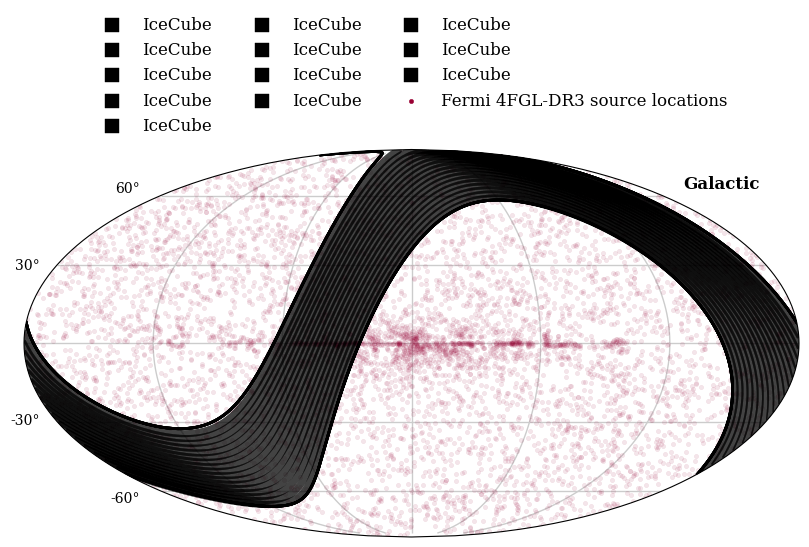

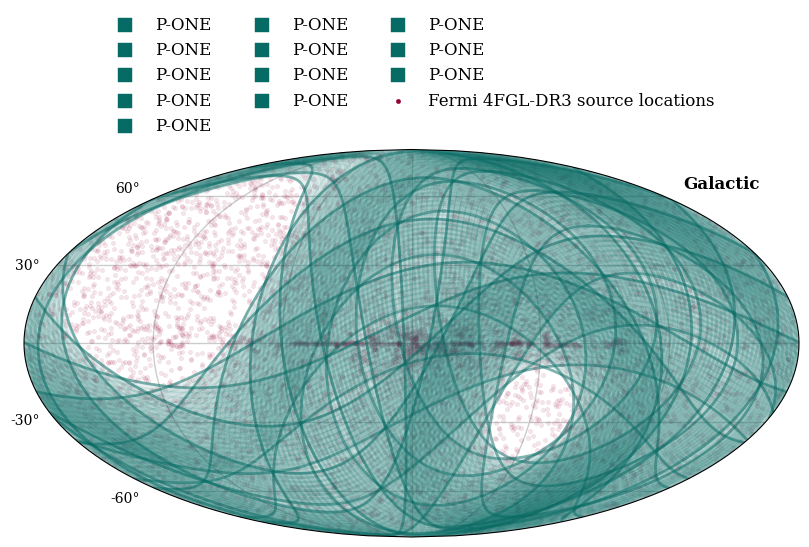

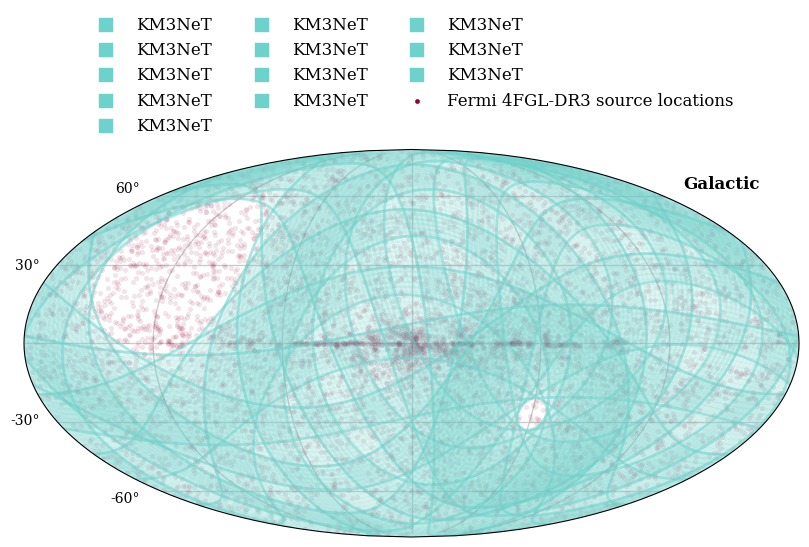

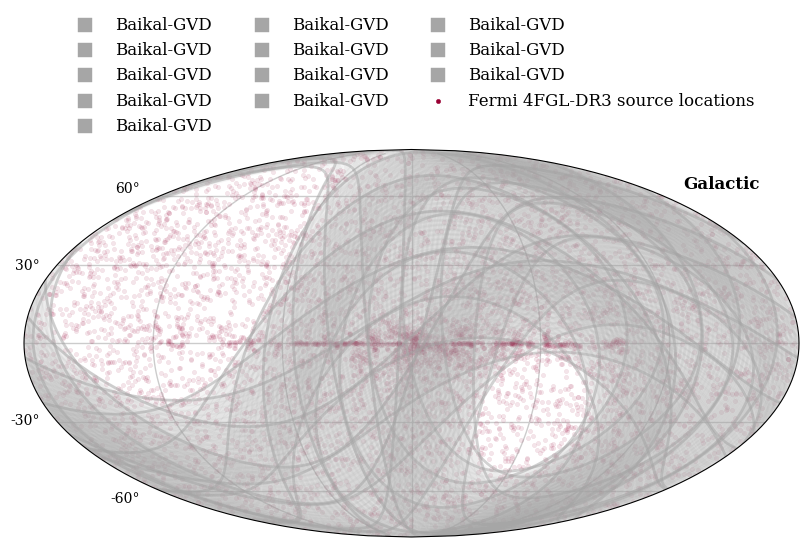

In [18]:
ii = 0
clon = 0
for k in plenum_detectors:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=clon))
    ax.set_global()
    ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, zorder=0)

    ax.text(0.15, 0.9, "60°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.02, 0.7, "30°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.02, 0.3, "-30°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.15, 0.1, "-60°", transform=ax.transAxes, ha="right", va="center")

    zen_min = -30
    zen_max = 5
    azi = np.linspace(0, 360, num=200)
    zen0 = np.full_like(azi, 0)  # exact horizon, for reference
    zen1 = np.full_like(azi, zen_min)
    zen2 = np.full_like(azi, zen_max)
    for rot in np.arange(0, 360, step=30):
        # just for legend
        ax.scatter(
            -1000,
            -1000,
            color=poles[k]["color"],
            marker="s",
            s=100,
            transform=ccrs.PlateCarree(),
            label=k,
            zorder=10,
        )
        pole_coord = SkyCoord(
            poles[k]["lon"].value + rot,
            poles[k]["lat"].value,
            unit="deg",
        )

        rotated_crs = ccrs.RotatedPole(
            pole_longitude=np.pi - pole_coord.galactic.l.deg,
            pole_latitude=pole_coord.galactic.b.deg,
        )
        if False:
            ax.plot(
                azi,
                zen0,
                transform=rotated_crs,
                color=poles[k]["color"],
                lw=3,
                alpha=1,
                ls="--",
            )
        ax.plot(azi, zen1, transform=rotated_crs, color=poles[k]["color"], lw=2, alpha=0.5)
        ax.plot(azi, zen2, transform=rotated_crs, color=poles[k]["color"], lw=2, alpha=0.5)

        for i in range(zen_min + 2, zen_max, 2):
            zen = np.full_like(azi, i)
            ax.plot(
                azi,
                zen,
                transform=rotated_crs,
                color=poles[k]["color"],
                lw=5,
                alpha=0.1,
            )
    fgl_kw = dict(
        color="#990033",
        marker="o",
        s=10,
        transform=ccrs.PlateCarree(central_longitude=clon),
    )
    ax.scatter(
        -skycoords_4FGL.galactic.l.deg,
        skycoords_4FGL.galactic.b.deg,
        alpha=0.1,
        **fgl_kw,
        # label="Fermi 4FGL-DR3"
    )
    ax.scatter(-1000, -1000, alpha=1, label="Fermi 4FGL-DR3 source locations", **fgl_kw)
    if False:
        ax.scatter(
            -skycoords_4FGL[txs_mask].galactic.l.deg,
            skycoords_4FGL[txs_mask].galactic.b.deg,
            marker="o",
            s=50,
            color="tomato",
            alpha=1,
            transform=ccrs.PlateCarree(central_longitude=clon),
        )
    plt.subplots_adjust(top=0.8)
    ax.legend(
        fontsize="large",
        loc="lower center",
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, 1.0),
    )
    ax.text(
        0.85, 0.9, "Galactic", transform=ax.transAxes, fontsize="large", fontweight="bold"
    )


# Detection efficiency for each telescope in (ra,dec) for one time stamp and integrated

In [19]:
with open(join(LOCALPATH, "rel_events_ra_dec.pckl"), "rb") as f:
    rel_events_ra_dec, ra_vals, dec_vals = pickle.load(f)

with open(join(LOCALPATH, "inst_rel_events_ra_dec.pckl"), "rb") as f:
    inst_rel_events_ra_dec, ra_vals, dec_vals = pickle.load(f)


In [104]:
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import ListedColormap


In [126]:
ncolors = 15
color_array = sns.color_palette("Blues", n_colors=ncolors)
alpha_c = []
for ii, a in enumerate(np.linspace(0, 1, ncolors)):
    _list = list(color_array[ii])
    _list.append(a)
    alpha_c.append(_list)
cmap_alpha = ListedColormap(alpha_c)
cmap = ListedColormap(color_array)

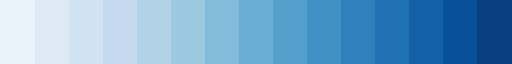

In [127]:
cmap

# time integrated PLEnuM

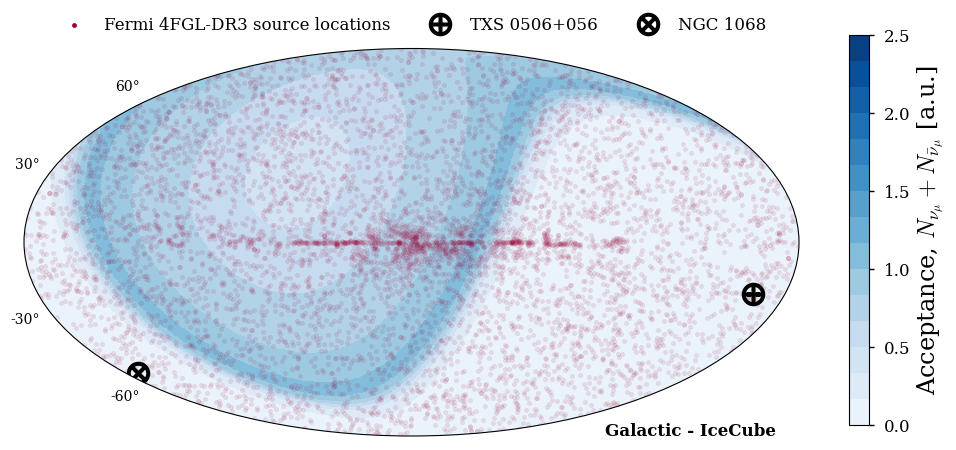

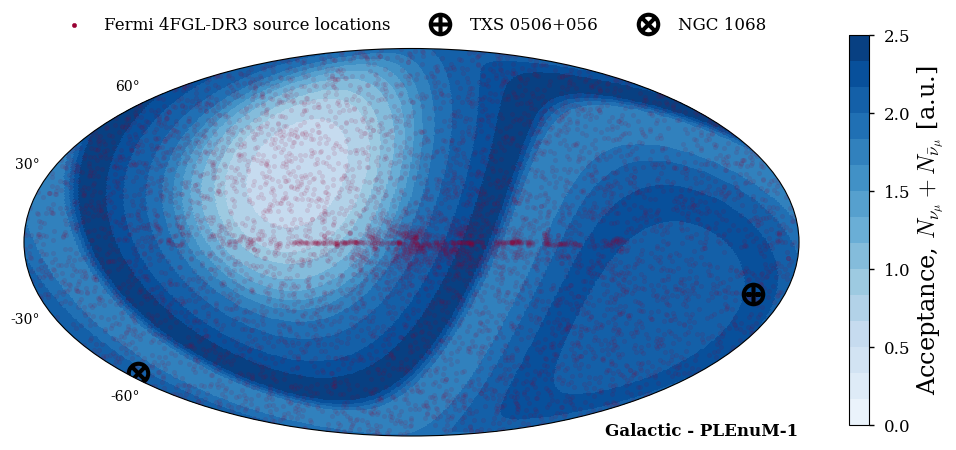

In [168]:
for ev, _label in zip(
    [rel_events_ra_dec[2]["IceCube"], rel_events_ra_dec[2]["Plenum-1"]],
    ("Galactic - IceCube", "Galactic - PLEnuM-1"),
):
    grid_eq = RegularGridInterpolator(
        (dec_vals, ra_vals),
        ev,
        bounds_error=False,
        fill_value=None,
    )
    pp, tt = np.meshgrid(ra_vals, dec_vals)
    _coords = SkyCoord(pp * u.radian, tt * u.radian, frame="galactic")
    _arr = grid_eq((_coords.icrs.dec.rad, _coords.icrs.ra.rad))

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection="mollweide")
    # ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, zorder=0)
    fgl_kw = dict(
        color="#990033",
        marker="o",
        s=10,
        zorder=10,
        # transform=ccrs.PlateCarree(central_longitude=clon),
    )
    ax.scatter(
        np.pi - (skycoords_4FGL.galactic.l.rad + np.pi) % (2 * np.pi),
        skycoords_4FGL.galactic.b.rad,
        alpha=0.1,
        **fgl_kw,
        # label="Fermi 4FGL-DR3"
    )
    if False:
        # just to check that TXS 0506+056 is at the right position
        ax.scatter(
            np.pi - (skycoords_4FGL[txs_mask].galactic.l.rad + np.pi) % (2 * np.pi),
            skycoords_4FGL[txs_mask].galactic.b.rad,
            alpha=1,
            label="Fermi 4FGL-DR3 source locations",
            color="green",
            s=100,
            zorder=10,
        )
    else:
        # for legend
        ax.scatter(
            -1000,
            -1000,
            alpha=1,
            label="Fermi 4FGL-DR3 source locations",
            **fgl_kw,
        )

    ax.text(0.15, 0.9, "60°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.02, 0.7, "30°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.02, 0.3, "-30°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.15, 0.1, "-60°", transform=ax.transAxes, ha="right", va="center")
    ax.set_yticklabels([])

    cax = ax.pcolormesh(
        ra_vals - np.pi,
        dec_vals,
        _arr,
        vmin=0,
        vmax=2.5,
        cmap=cmap,
        linewidth=0,
        rasterized=True,
    )

    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.65])
    cbar = fig.colorbar(cax, cax=cbar_ax)
    # cbar.set_label(
    #     rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$",
    #     fontsize="xx-large",
    # )
    cbar.set_label(
        r"Acceptance, $N_{\nu_{\mu}} + N_{\bar{\nu}_{\mu}}$ [a.u.]",
        fontsize="xx-large",
    )
    cbar.ax.tick_params(labelsize="large")
    ax.text(
        0.75, 0.0, _label, transform=ax.transAxes, fontsize="large", fontweight="bold"
    )

    ax.plot(
        np.pi - (txs0506.galactic.l.rad + np.pi) % (2 * np.pi),
        txs0506.galactic.b.rad,
        marker=r"$\bigoplus$",
        c="k",
        markeredgewidth=2,
        ms=15,
        zorder=10,
        label="TXS 0506+056",
        lw=0,
    )
    ax.plot(
        np.pi - (ngc1068.galactic.l.rad + np.pi) % (2 * np.pi),
        ngc1068.galactic.b.rad,
        marker=r"$\bigotimes$",
        c="k",
        markeredgewidth=2,
        ms=15,
        zorder=10,
        label="NGC 1068",
        lw=0,
    )
    plt.subplots_adjust(top=0.8)
    ax.legend(
        fontsize="large",
        loc="lower center",
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, 1.0),
    )
    base_file = join(BASEPATH, f"plots/maps/plenum-1_galactic_4FGL_" + _label)
    fig.savefig(base_file + ".pdf", bbox_inches="tight")

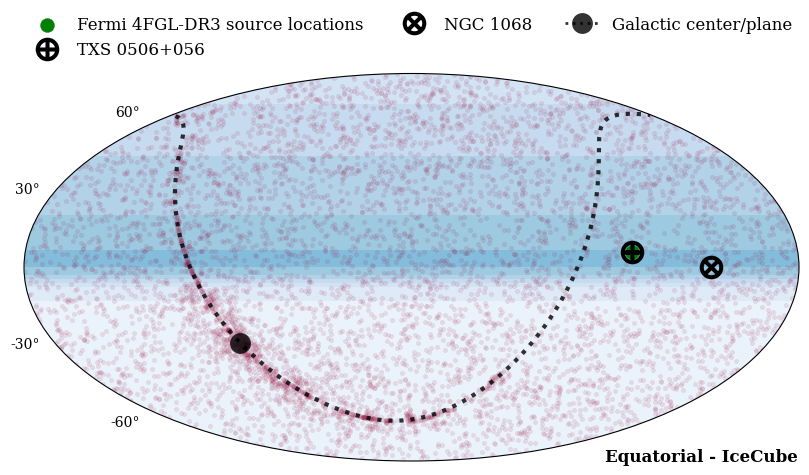

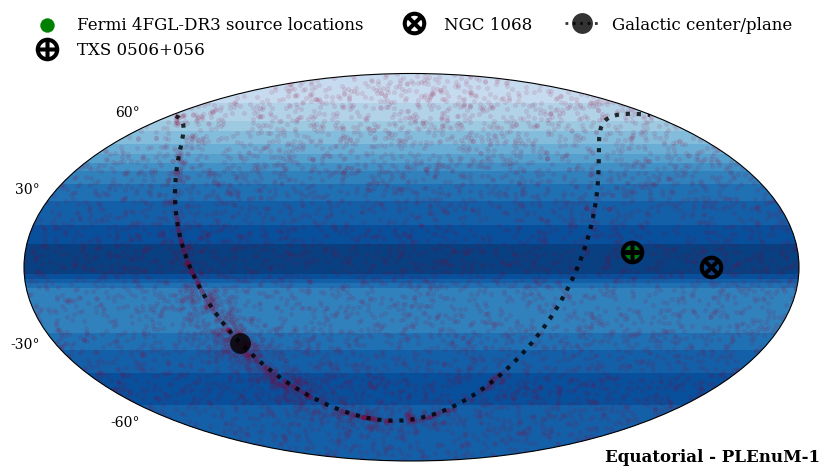

In [167]:
## equatorial coordinates
for _arr, _label in zip(
    [rel_events_ra_dec[2]["IceCube"], rel_events_ra_dec[2]["Plenum-1"]],
    ("Equatorial - IceCube", "Equatorial - PLEnuM-1"),
):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection="mollweide")
    # ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, zorder=0)
    fgl_kw = dict(
        color="#990033",
        marker="o",
        s=10,
        zorder=10,
        # transform=ccrs.PlateCarree(central_longitude=clon),
    )
    ax.scatter(
        np.pi - skycoords_4FGL.ra.rad,
        skycoords_4FGL.dec.rad,
        alpha=0.1,
        **fgl_kw,
        # label="Fermi 4FGL-DR3"
    )
    if True:
        # just to check that TXS 0506+056 is at the right position
        ax.scatter(
            np.pi - skycoords_4FGL[txs_mask].ra.rad,
            skycoords_4FGL[txs_mask].dec.rad,
            alpha=1,
            label="Fermi 4FGL-DR3 source locations",
            color="green",
            s=100,
            zorder=10,
        )
    else:
        # for legend
        ax.scatter(
            -1000,
            -1000,
            alpha=1,
            label="Fermi 4FGL-DR3 source locations",
            **fgl_kw,
        )

    ax.text(0.15, 0.9, "60°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.02, 0.7, "30°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.02, 0.3, "-30°", transform=ax.transAxes, ha="right", va="center")
    ax.text(0.15, 0.1, "-60°", transform=ax.transAxes, ha="right", va="center")
    ax.set_yticklabels([])

    cax = ax.pcolormesh(
        ra_vals - np.pi,
        dec_vals,
        _arr,
        vmin=0,
        vmax=2.5,
        cmap=cmap,
        linewidth=0,
        rasterized=True,
    )
    if False:
        cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.65])
        cbar = fig.colorbar(cax, cax=cbar_ax)
        # cbar.set_label(
        #     rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$",
        #     fontsize="xx-large",
        # )
        cbar.set_label(
            r"Acceptance, $N_{\nu_{\mu}} + N_{\bar{\nu}_{\mu}}$ [a.u.]",
            fontsize="xx-large",
        )
        cbar.ax.tick_params(labelsize="large")
    ax.text(
        0.75, 0.0, _label, transform=ax.transAxes, fontsize="large", fontweight="bold"
    )

    ax.plot(
        np.pi - txs0506.ra.rad,
        txs0506.dec.rad,
        marker=r"$\bigoplus$",
        c="k",
        markeredgewidth=2,
        ms=15,
        zorder=10,
        label="TXS 0506+056",
        lw=0,
    )
    ax.plot(
        np.pi - ngc1068.ra.rad,
        ngc1068.dec.rad,
        marker=r"$\bigotimes$",
        c="k",
        markeredgewidth=2,
        ms=15,
        zorder=10,
        label="NGC 1068",
        lw=0,
    )
    add_plane(
        ax, color="black", zorder=10
    )
    plt.subplots_adjust(top=0.8)
    ax.legend(
        fontsize="large",
        loc="lower center",
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, 1.0),
    )
    base_file = join(BASEPATH, f"plots/maps/plenum-1_equatorial_4FGL"+_label)
    fig.savefig(base_file + ".pdf", bbox_inches="tight")

# ... some older plots

### instantaneous field of view

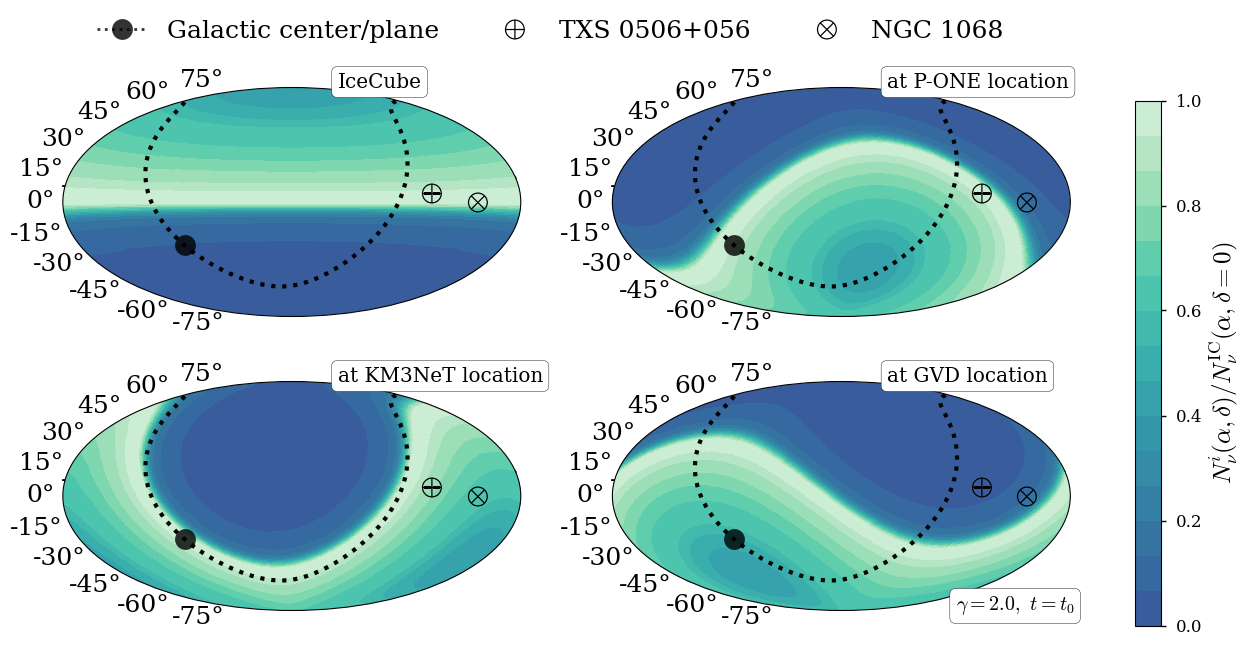

In [19]:
fig = plt.figure(figsize=(13, 7))
n2ind = {"IceCube": 221, "P-ONE": 222, "KM3NeT": 223, "Baikal-GVD": 224}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(inst_rel_events_ra_dec[gamma].items()):
    if "Plenum" in name or name == "Gen-2":
        continue
    ax = fig.add_subplot(n2ind[name], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap=cmap)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        poles[name]["label"],
        fontsize="x-large",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
ax.text(
    0.75,
    0,
    rf"$\gamma={gamma},~t=t_0$",
    transform=ax.transAxes,
    fontsize="x-large",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
)
fig.legend(
    #fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$"
)
cbar.ax.tick_params(labelsize="large")
fig.savefig(join(BASEPATH, "plots/skymaps_local_time.pdf"), bbox_inches="tight")


## only p-one for different times to show rotation

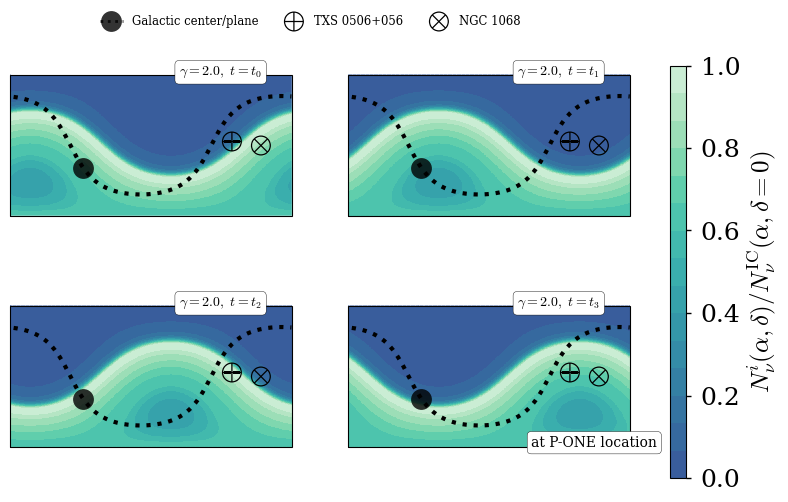

In [20]:
fig, axes = plt.subplots(
    2, 2, #figsize=(13, 7), 
    subplot_kw=dict(projection=ccrs.PlateCarree())
)
gamma = 2.0
make_legend = True
name = "P-ONE"
vals = inst_rel_events_ra_dec[gamma][name]
for i, clon in enumerate([0, 90, 180, 270]):
    ax = axes.flatten()[i]
    cax = ax.pcolormesh(
        np.rad2deg(ra_vals),
        np.rad2deg(dec_vals),
        vals,
        vmin=0,
        vmax=1,
        cmap=cmap,
        transform=ccrs.PlateCarree(central_longitude=clon),
    )
    if make_legend:
        add_plane(ax, color="black", transform=ccrs.PlateCarree())
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", transform=ccrs.PlateCarree())
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", transform=ccrs.PlateCarree())
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__", transform=ccrs.PlateCarree())
        add_obj(
            ax,
            "txs",
            marker=r"$\bigoplus$",
            c="k",
            label="__None__",
            transform=ccrs.PlateCarree(),
        )
        add_obj(
            ax,
            "ngc",
            marker=r"$\bigotimes$",
            c="k",
            label="__None__",
            transform=ccrs.PlateCarree(),
        )
    ax.text(
        0.6,
        1.0,
        rf"$\gamma={gamma},~t=t_{i}$",
        #fontsize="medium",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
ax.text(
    0.65,
    0,
    poles[name]["label"],
    transform=ax.transAxes,
    #fontsize="small",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
)
fig.legend(
    fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$"
)
#cbar.ax.tick_params(labelsize="large")
fig.savefig(join(BASEPATH, 'plots/skymaps_local_time.pdf'), bbox_inches="tight")


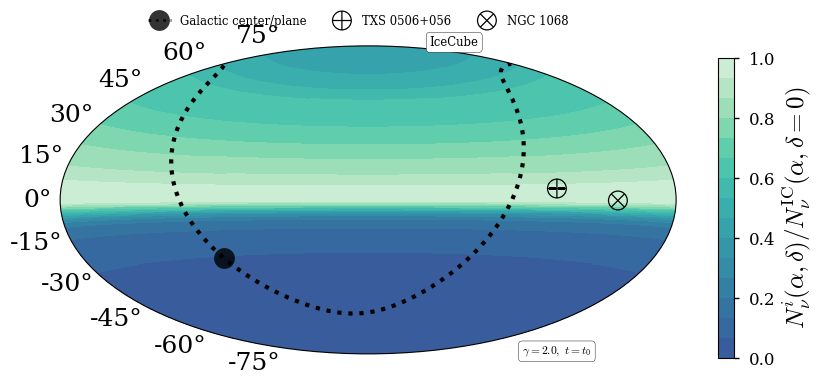

In [21]:
fig = plt.figure(figsize=(8, 4))
n2ind = {"IceCube": 111}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(inst_rel_events_ra_dec[gamma].items()):
    if name != "IceCube":
        continue
    ax = fig.add_subplot(n2ind[name], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap=cmap)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        poles[name]["label"],
        fontsize="small",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
ax.text(
    0.75,
    0,
    rf"$\gamma={gamma},~t=t_0$",
    transform=ax.transAxes,
    fontsize="small",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
)
fig.legend(
    fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$"
)
cbar.ax.tick_params(labelsize="large")


## time integrated

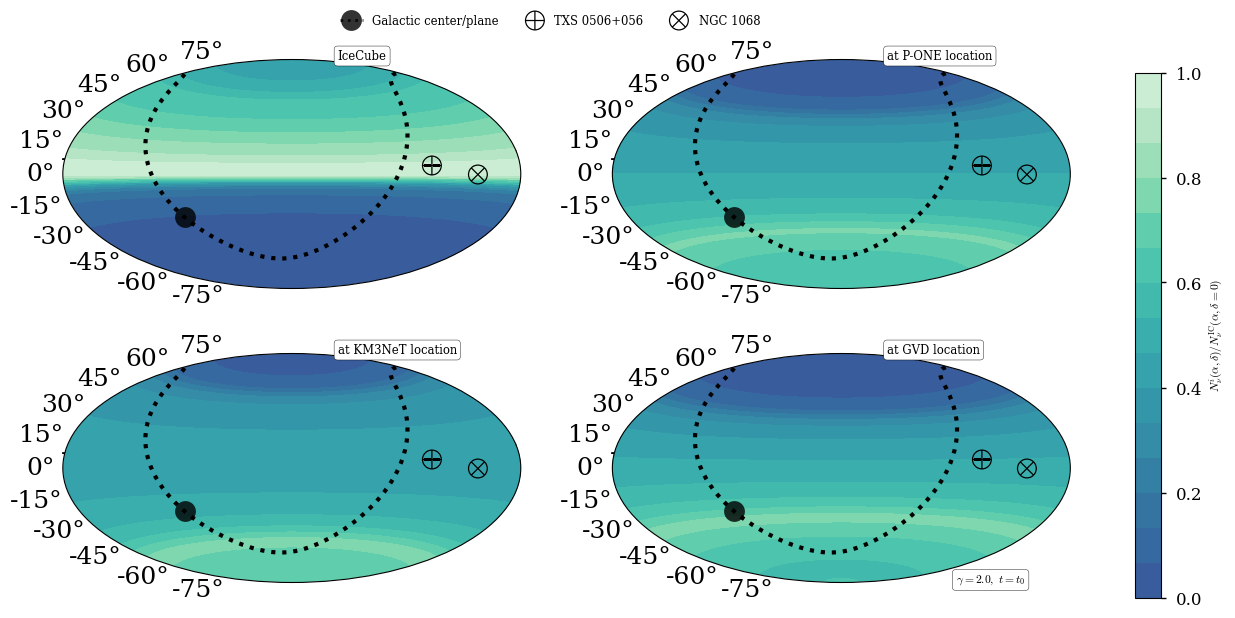

In [22]:
fig = plt.figure(figsize=(13, 7))
n2ind = {"IceCube": 221, "P-ONE": 222, "KM3NeT": 223, "Baikal-GVD": 224}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(rel_events_ra_dec[gamma].items()):
    if "Plenum" in name or name == "Gen-2":
        continue
    ax = fig.add_subplot(n2ind[name], projection="hammer", rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap=cmap)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        make_legend = False
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.6,
        1.0,
        poles[name]["label"],
        fontsize="small",
        transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
    )
ax.text(
    0.75,
    0,
    rf"$\gamma={gamma},~t=t_0$",
    transform=ax.transAxes,
    fontsize="small",
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
)
fig.legend(
    fontsize="small",
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.9),
)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    rf"$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$",
    fontsize="small",
)
cbar.ax.tick_params(labelsize="large")
fig.savefig(join(BASEPATH, "plots/skymaps_time_integrated.pdf"), bbox_inches="tight")


### integrated field of view with (-5°,30°) band, IceCube HESE events and catalog

In [23]:
from tools import _trans


In [ ]:
tracks = np.load(join(BASEPATH, "resources/tracks.npy"))
ang_unc = np.empty(len(tracks), dtype=float)
for i, ra_err in enumerate(tracks["ra_err"]):
    name = tracks["name"][i]
    if b"HES" in name and not b"AHES" in name:
        ang_unc[i] = ra_err[0]
    else:
        Dec_err = np.mean([tracks["dec_err"][i][0], -tracks["dec_err"][i][1]])
        Ra_err = np.mean([ra_err[0], -ra_err[1]])
        ang_unc[i] = conv2ang_uncertainty(Ra_err, Dec_err, tracks["dec"][i])
tracks = np.lib.recfunctions.append_fields(
    tracks, names="sigma", data=ang_unc, dtypes=float, usemask=False
)

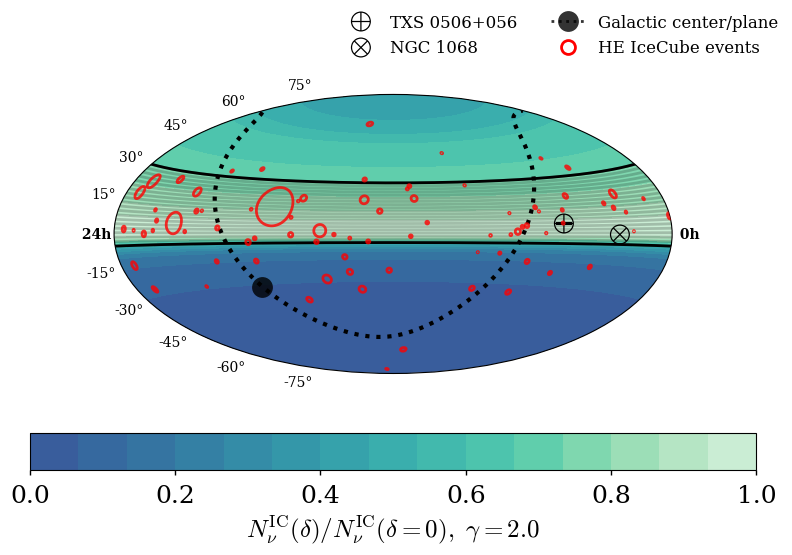

In [24]:
num = len(ra_vals)
for gamma in [2.0]:
    fig = plt.figure()  # figsize=(10, 7.0))
    ax = fig.add_subplot(111, projection="hammer", rasterized=True)
    cax = ax.pcolormesh(
        ra_vals - np.pi,
        dec_vals,
        rel_events_ra_dec[gamma]["IceCube"],
        vmin=0,
        vmax=1,
        cmap=cmap,
    )
    cbar = fig.colorbar(cax, orientation="horizontal")
    cbar.set_label(
        rf"$N_{{\nu}}^{{\rm IC}}(\delta) / N_{{\nu}}^{{\rm IC}}(\delta=0),~\gamma={gamma}$",
        # fontsize="large",
    )
    # cbar.ax.tick_params(labelsize="medium")
    # ---------------------------------------
    # show the IceCube lines between -5 and 30 deg
    # ---------------------------------------
    c = "k"  # "#DC6C25"
    y1 = np.tile(np.radians(-5.0), num)
    y2 = np.tile(np.radians(30), num)

    _x, _y1 = _trans(ra_vals, y1)
    _x, _y2 = _trans(ra_vals, y2)
    ind = np.argsort(_x)
    ax.plot(_x[ind], _y1[ind], color=c)
    ax.plot(_x[ind], _y2[ind], color=c)

    for y_i in np.linspace(-5, 30, num=20, endpoint=True):
        ytmp = np.tile(y_i, len(ra_vals))
        _x2, _y2 = _trans(ra_vals, np.radians(ytmp))
        ind = np.argsort(_x2)
        ax.plot(np.sort(_x2), _y2[ind], color=c, alpha=0.2)

    #  add also txs0506 and NGC1068
    add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
    add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")

    # add event with error radius
    for i, (rai, deci, si) in enumerate(
        zip(tracks["ra"], tracks["dec"], tracks["sigma"])
    ):
        c = "red"
        if i == 0:
            res = add_event(
                ax,
                ra_i=np.radians(rai),
                dec_i=np.radians(deci),
                sigma_i=np.radians(si),
                labels=["IceCube HE events"],
                color=c,
                linewidths=2.0,
                zorder=10,
            )
        else:
            add_event(
                ax,
                ra_i=np.radians(rai),
                dec_i=np.radians(deci),
                sigma_i=np.radians(si),
                color=c,
                linewidths=2.0,
                zorder=10,
            )

    # fix the labels
    set_ticks(ax, fs="medium")
    # add the galactic center and plane
    add_plane(ax, color="black")

    # get all legend entries and add the circle for the HE events
    handles, labels = ax.get_legend_handles_labels()
    HE_events = Line2D(
        range(1),
        range(1),
        color="red",
        marker="o",
        mew=2,
        markersize=10,
        markerfacecolor="None",
        linestyle="None",
        label="HE IceCube events",
    )
    handles.append(HE_events)
    fig.legend(
        handles=handles,
        fontsize="large",
        # mode="expand",
        ncol=2,
        frameon=False,
    )

    fig.tight_layout()
    plt.subplots_adjust(top=0.83)  # , bottom=0.2)
    # fig.savefig(
    #     f"../plots/IceCube_Skymap_horizon_gamma{int(np.round(gamma*10))}.pdf",
    #     bbox_inches="tight",
    #     dpi=200,
    # )
    # plt.show()


# Plenum improvements 
.. in discovery potential for gamma=2 and the same amount of time.
This plot shows a direct comparison of plenum and IceCube for equal run times

Idea:

* Discovery potential improvement:

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8}$

* Improvement relative to IceCube at horizon $(\delta=0)$:

$R_0 = \left( \frac{\int dE \cdot A_{\rm eff, new}(\delta) \cdot d\Phi/dE}{\int dE \cdot A_{\rm eff, IC}(\delta=0) \cdot d\Phi/dE} \right)^{0.8}$

* Improvement relative to IceCube at resp. declination:

$R_{rel} = \left( \frac{\int dE \cdot A_{\rm eff, new}(\delta) \cdot d\Phi/dE}{\int dE \cdot A_{\rm eff, IC}(\delta) \cdot d\Phi/dE} \right)^{0.8}$

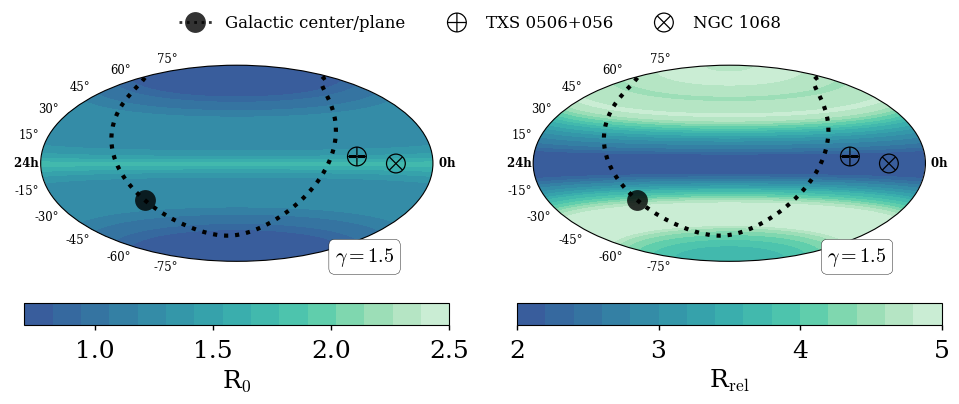

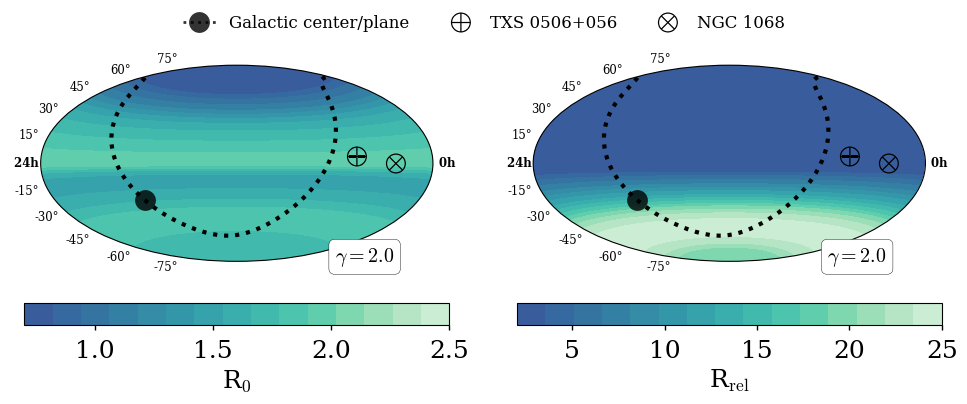

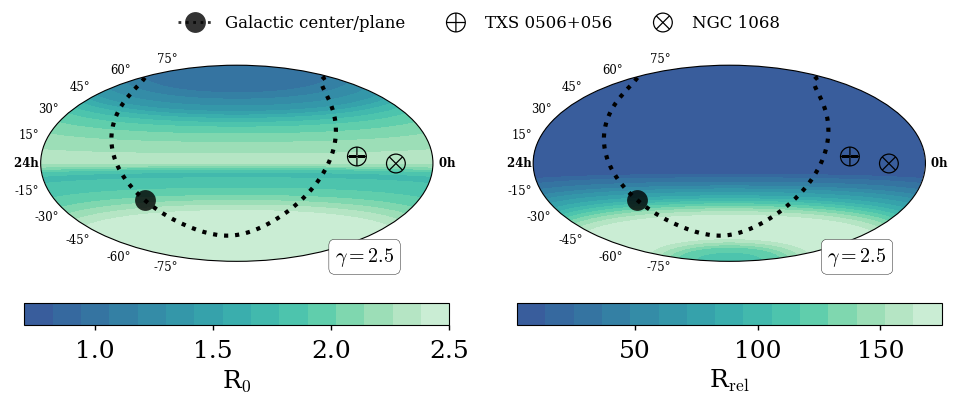

In [25]:
i2ind = {0: 121, 1: 122}
# Options:
# R0: comparison to IceCube at horizon
# R_rel: comparison to IceCube at respective declination
variation = ["r0", "rrel"]
labels = {"r0": r"R$_0$", "rrel": r"R$_{\mathrm{rel}}$"}
# min, max for colorbar, because there are some numeric hiccups at the poles
extreme = {
    1.5: {"r0": (0.7, 2.5), "rrel": (2.0, 5.0)},
    2.0: {"r0": (0.7, 2.5), "rrel": (2.0, 25.0)},
    2.5: {"r0": (0.7, 2.5), "rrel": (2.0, 175.0)},
}

for gamma in [1.5, 2.0, 2.5]:
    fig = plt.figure(figsize=(10, 4))
    for i, vari in enumerate(variation):
        ax = fig.add_subplot(i2ind[i], projection="hammer", rasterized=True)
        comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])

        if vari == "rrel":
            mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
            comb_vals[mask] = (
                rel_events_ra_dec[gamma]["Plenum-1"][mask]
                / rel_events_ra_dec[gamma]["IceCube"][mask]
            ) ** 0.8
        else:
            comb_vals = (
                rel_events_ra_dec[gamma]["Plenum-1"]
                / rel_events_ra_dec[gamma]["IceCube"][
                    len(rel_events_ra_dec[gamma]["IceCube"]) // 2
                ]
            ) ** 0.8
        _min, _max = extreme[gamma][vari]

        cax = ax.pcolormesh(
            ra_vals - np.pi, dec_vals, comb_vals, vmin=_min, vmax=_max, cmap=cmap
        )

        cbar = fig.colorbar(cax, orientation="horizontal")
        #cbar.ax.tick_params(labelsize="small")
        cbar.set_label(labels[vari]) #, fontsize="small")
        set_ticks(ax, fs="small")
        # add the galactic center and plane
        if i == 0:
            add_plane(ax, color="black")
            add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
            add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
        else:
            add_plane(ax, color="black", label="__None__")
            add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
            add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
        ax.text(
            0.75,
            0,
            rf"$\gamma={gamma}$",
            transform=ax.transAxes,
            fontsize="x-large",
            bbox=dict(boxstyle="round", facecolor="w", edgecolor="k"),
        )

    fig.legend(
        fontsize="large", 
        loc="upper center", ncol=4, frameon=False
    )  # ,  mode='expand')
    fig.tight_layout()
    plt.subplots_adjust(top=0.84)  # , bottom=0.2)


# Show the time evolution of plenum

This plot will show how plenum improves (after x years) the total discovery potential if we turn it on after 10years of IceCube 

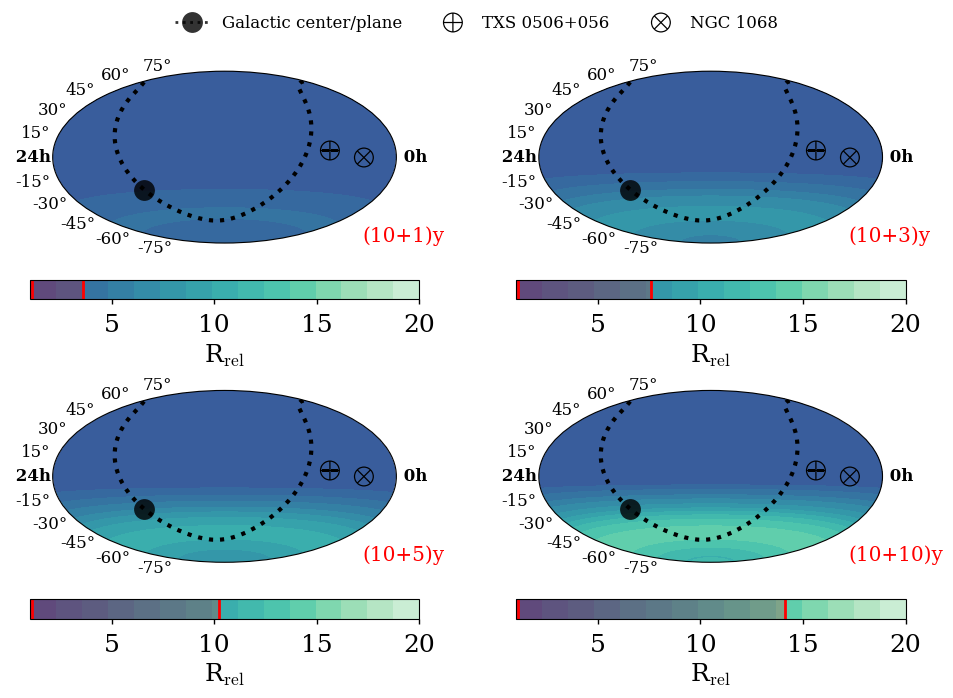

In [26]:
i2ind = {0: 221, 1: 222, 2: 223, 3: 224}
# Options:
# R0: comparison to IceCube at horizon
# R_rel: comparison to IceCube at respective declination
variation = ["r0", "rrel"]
labels = {"r0": r"R$_0$", "rrel": r"R$_{\mathrm{rel}}$"}
# min, max for colorbar, because there are some numeric hiccups at the poles
extreme = {1.0: (1.0, 20.0), 3.0: (1.0, 20.0), 5.0: (1.0, 20.0), 10.0: (1.0, 20.0)}
t_0 = 10.0  # years
t_news = [1.0, 3.0, 5.0, 10.0]  # years
gamma = 2.0
fig = plt.figure(figsize=(10, 7))
vari = "rrel"

for i, t_new in enumerate(t_news):
    comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
    ax = fig.add_subplot(i2ind[i], projection="hammer", rasterized=True)

    mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
    comb_vals[mask] = (
        rel_events_ra_dec[gamma]["Plenum-1"][mask]
        / rel_events_ra_dec[gamma]["IceCube"][mask]
        * t_new
        / (t_0 + t_new)
    ) ** 0.8
    _min, _max = extreme[t_new]
    cax = ax.pcolormesh(
        ra_vals - np.pi, dec_vals, comb_vals, vmin=_min, vmax=_max, cmap=cmap
    )
    cbar = fig.colorbar(cax, orientation="horizontal")
    #cbar.ax.tick_params(labelsize="large")
    cbar.set_label(labels[vari]) #, fontsize="large")

    cmarker_0 = _min + 0.005 * (_max - _min)
    cmarker_1 = np.max(comb_vals)
    cbar.ax.axvline(cmarker_0, color="red", lw=2)
    cbar.ax.axvline(cmarker_1, color="red", lw=2)
    # I have no idea how fill_between works for color axes :D
    cbar.ax.fill_between(
        [cmarker_0, cmarker_1], [-1, -1], [50, 50], color="red", alpha=0.2
    )

    set_ticks(ax, fs="large")
    # add the galactic center and plane
    if i == 0:
        add_plane(ax, color="black")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")
    else:
        add_plane(ax, color="black", label="__None__")
        add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
        add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")
    ax.text(
        0.9,
        0.01,
        r"({1:d}+{0:d})y".format(int(t_new), int(t_0)),
        ha="left",
        size="x-large",
        transform=ax.transAxes,
        color="red",
    )

fig.legend(
    fontsize="large", loc="upper center", ncol=4, frameon=False
)  # ,  mode='expand')
fig.tight_layout()
plt.subplots_adjust(top=0.9)  # , bottom=0.2)


## Show ratio including Gen2 

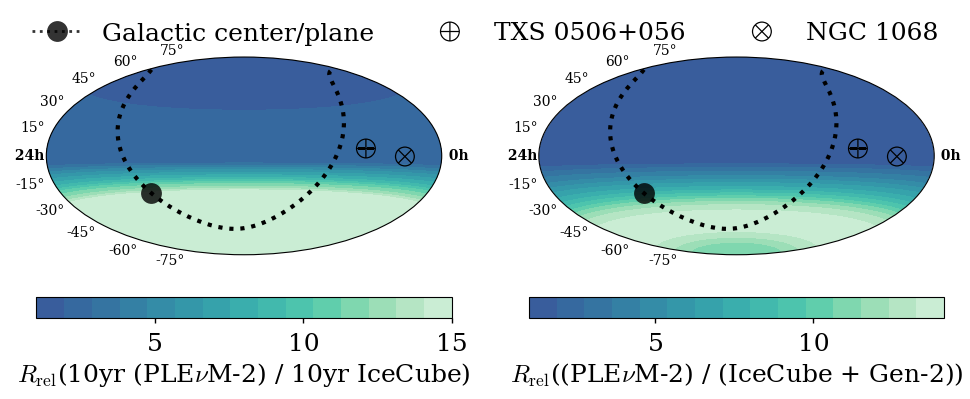

In [27]:
gamma = 2.0
fig = plt.figure(figsize=(10, 4))
vari = "rrel"
_min, _max = (1.0, 15.0)

comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0

ax = fig.add_subplot(121, projection="hammer", rasterized=True)
## 10yrs of Plenum including Gen-2 (subtracting IceCube events from original Plenum events)
## vs 20yrs of IceCube
comb_vals[mask] = (
    (rel_events_ra_dec[gamma]["Plenum-2"][mask])
    / rel_events_ra_dec[gamma]["IceCube"][mask]
) ** 0.8
cax = ax.pcolormesh(
    ra_vals - np.pi, dec_vals, comb_vals, vmin=_min, vmax=_max, cmap=cmap
)
cbar = fig.colorbar(cax, orientation="horizontal")
# cbar.ax.tick_params(labelsize="medium")
cbar.set_label(
    r"$R_{\mathrm{rel}}$(10yr (PLE$\nu$M-2) / 10yr IceCube)",  # fontsize="medium"
)

set_ticks(ax, fs="medium")
# add the galactic center and plane
add_plane(ax, color="black")
add_obj(ax, "txs", marker=r"$\bigoplus$", c="k")
add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k")

comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
ax = fig.add_subplot(122, projection="hammer", rasterized=True)
## 10yrs of Plenum including Gen-2 (subtracting IceCube events from original Plenum events)
## vs 10yrs of IceCube plus 10yrs of Gen2
comb_vals[mask] = (
    (rel_events_ra_dec[gamma]["Plenum-2"][mask])
    / (
        rel_events_ra_dec[gamma]["IceCube"][mask]
        + rel_events_ra_dec[gamma]["Gen-2"][mask]
    )
) ** 0.8
cax = ax.pcolormesh(
    ra_vals - np.pi, dec_vals, comb_vals, vmin=_min, cmap=cmap  # vmax=_max,
)
cbar = fig.colorbar(cax, orientation="horizontal")
# cbar.ax.tick_params(labelsize="medium")
cbar.set_label(
    r"$R_{\mathrm{rel}}$((PLE$\nu$M-2) / (IceCube + Gen-2))",  # fontsize="medium"
)

set_ticks(ax, fs="medium")
# add the galactic center and plane
add_plane(ax, color="black", label="__None__")
add_obj(ax, "txs", marker=r"$\bigoplus$", c="k", label="__None__")
add_obj(ax, "ngc", marker=r"$\bigotimes$", c="k", label="__None__")

fig.legend(
    # fontsize="large",
    loc="upper center",
    ncol=4,
    frameon=False,
)  # ,  mode='expand')
fig.tight_layout()
plt.subplots_adjust(top=0.85)  # , bottom=0.2)
